In [1]:
# Libraries
import numpy as np
import scipy.io as sio
import os
# import pickle
# import ieeg_funcs as ief
# import re
import dgFuncs as dg
from sklearn import preprocessing
# from scipy import stats
# from mpl_toolkits.axes_grid1 import make_axes_locatable
#rom sklearn import svm, linear_model
from sklearn.cluster import KMeans
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def kmeans_downsample(ftrs,downsample_fact):
    """ ftrs = observations x ftr """
    n_obs=ftrs.shape[0]
    print('%d observations, %d ftrs' % (n_obs,ftrs.shape[1]))
    k=int(np.round(n_obs/downsample_fact))
    print('Trying %d clusters' % k)
    kclusters = KMeans(n_clusters=k).fit(ftrs)
    return kclusters, k

In [4]:
# Load raw ftrs
ftr_fname='/Users/davidgroppe/Desktop/train_ftrs_aes.npz'
npz=np.load(ftr_fname)
print(npz.keys())

['ftrs', 'szr_class', 'sub_id', 'train_subs_list']


In [10]:
#downsample_fact=1000
downsample_fact=10
#sub_list=npz['train_subs_list'][:2]
sub_list=npz['train_subs_list']

# Figure out how much data to preallocate
n_downsamp_obs=0
n_dim=npz['ftrs'].shape[1]
for sub in sub_list:
    ictal_bool=np.multiply(npz['sub_id']==sub,npz['szr_class']==1)
    nonictal_bool=np.multiply(npz['sub_id']==sub,npz['szr_class']==0)
    n_ictal=np.sum(ictal_bool)
    n_nonictal=np.sum(nonictal_bool)
    print('Sub %d, n_ictal=%d, n_nonictal=%d' % (sub,n_ictal,n_nonictal))
    n_downsamp_obs+=int(np.round(n_ictal/downsample_fact))+int(np.round(n_nonictal/downsample_fact))
print('# of total downsampled windows %d' % n_downsamp_obs)

# Preallocate memory
#['ftrs', 'szr_class', 'sub_id', 'train_subs_list']
ftrs_dsamp=np.zeros((n_downsamp_obs,n_dim))
sub_ids_dsamp=np.zeros(n_downsamp_obs)
szr_class_dsamp=np.zeros(n_downsamp_obs)

obs_ct=0
for sub in sub_list:
    print('Working on sub %d' % sub)
    # Cluster ictal observations
    print('Clustering ictal observations')
    ictal_bool=np.multiply(npz['sub_id']==sub,npz['szr_class']==1)
    ictal_kclusters, k=kmeans_downsample(npz['ftrs'][ictal_bool,:],downsample_fact)
    obs_ct_stop=obs_ct+k
    sub_ids_dsamp[obs_ct:obs_ct_stop]=sub
    ftrs_dsamp[obs_ct:obs_ct_stop,:]=ictal_kclusters.cluster_centers_
    szr_class_dsamp[obs_ct:obs_ct_stop]=1
    obs_ct+=k
    
    # Cluster non-ictal observations
    print('Clustering NONictal observations')
    nonictal_bool=np.multiply(npz['sub_id']==sub,npz['szr_class']==0)
    nonictal_kclusters, k=kmeans_downsample(npz['ftrs'][nonictal_bool,:],downsample_fact)
    obs_ct_stop=obs_ct+k
    sub_ids_dsamp[obs_ct:obs_ct_stop]=sub
    ftrs_dsamp[obs_ct:obs_ct_stop,:]=nonictal_kclusters.cluster_centers_
    szr_class_dsamp[obs_ct:obs_ct_stop]=0
    obs_ct+=k
    
print('Done')

Sub 253, n_ictal=27675, n_nonictal=28302
Sub 565, n_ictal=116933, n_nonictal=116928
Sub 590, n_ictal=31062, n_nonictal=33782
Sub 620, n_ictal=8210, n_nonictal=8960
Sub 958, n_ictal=28008, n_nonictal=30150
Sub 970, n_ictal=94927, n_nonictal=96669
Sub 1077, n_ictal=13314, n_nonictal=13651
Sub 1096, n_ictal=46818, n_nonictal=47190
# of total downsampled windows 74258
Working on sub 253
Clustering ictal observations
27675 observations, 30 ftrs
Trying 2768 clusters
Clustering NONictal observations
28302 observations, 30 ftrs
Trying 2830 clusters
Working on sub 565
Clustering ictal observations
116933 observations, 30 ftrs
Trying 11693 clusters


KeyboardInterrupt: 

done


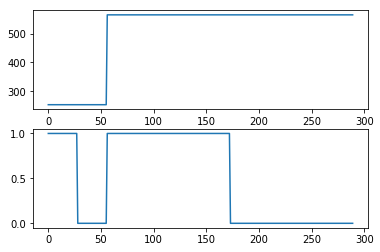

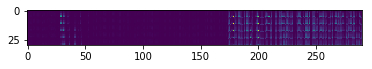

In [9]:
plt.figure(3)
plt.clf()
plt.subplot(2,1,1)
plt.plot(sub_ids_dsamp)
# plt.imshow(ftrs_dsamp)

plt.subplot(2,1,2)
plt.plot(szr_class_dsamp)

plt.figure(4)
plt.clf()
plt.imshow(ftrs_dsamp.T)

print('done')

['ftrs_dsamp', 'szr_class_dsamp']


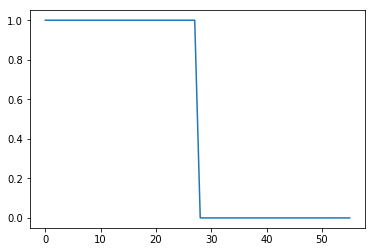

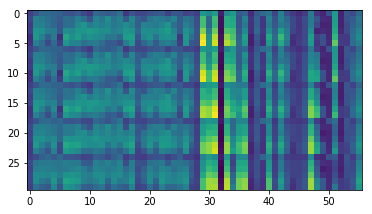

In [16]:
temp_fname='kdownsampled_253.npz'
bro=np.load(temp_fname)
print(bro.keys())

plt.figure(3)
plt.clf()
plt.plot(bro['szr_class_dsamp'])

plt.figure(4)
plt.clf()
mn_ftr=np.min(bro['ftrs_dsamp'])
plt.imshow(np.log10(bro['ftrs_dsamp'].T-mn_ftr+1));